線形回帰  


*   単純な線形回帰
*   基底関数を使った線形回帰
*   多項式基底関数
*   ガウス基底関数
*   正則化
*   L2正則化
*   L1正則化
*   実例


単純な線形回帰

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

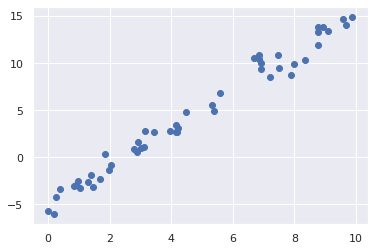

In [ ]:
#　傾き2,切片-5の一次関数
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y)

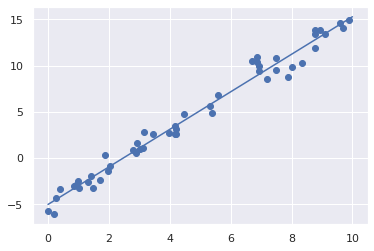

In [ ]:
# 線形回帰→LinearRegression
# 引数　fit_intercept→Tureだと切片の計算を含める
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

# テストデータ作成、予測
xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

In [ ]:
# 作成したモデルの切片、傾きは.coef_、.intersept_で出せる
print("Model slope    :", model.coef_[0])
print("Model intersept:", model.intercept_)
# だいたい傾き2、切片-5だから合ってる

Model slope    : 2.0272088103606953
Model intersept: -4.998577085553204


In [ ]:
# n次元データにも線形回帰は使える
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.5000000000000051
[ 1.5 -2.   1. ]


基底関数を使った回帰  

多項式基底関数  

In [ ]:
#PolynomialFeatures(べき乗を求めるやつ)で3次元のデータにする
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])
#x[:. None]はnp.newaxisと同じ
#.fit_transformにしないと変換されない

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

In [ ]:
#PolynomialFeaturesしてからLinearRegression(回帰)するパイプラインを作る
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

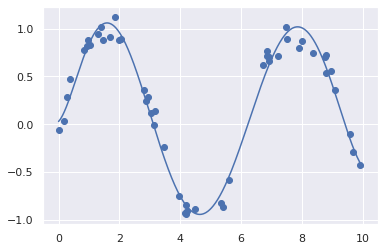

In [ ]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])
#xfit = np.linspace(0, 10, 1000)
#xfitをPolynomialFeaturesしてからLinearRegressionモデルで.predictした

plt.scatter(x, y)
plt.plot(xfit, yfit);

ガウス基底関数  

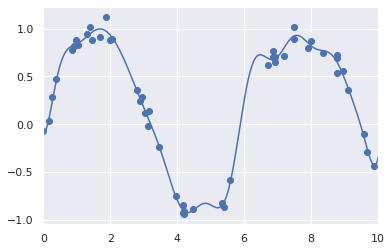

In [ ]:
#ガウス基底はscikit-learnに組み込まれてないので自分で作らなきゃいけない
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    #1次元入力のときのガウス基底
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    #ガウス基底の式
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        #データの最大最小を使ってN個までガウス基底を拡張
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    #ガウス基底の式を使って変換
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)
    
#GaussianFeaturesしてLinearRegressionするパイプラインを作って.fitして.predict
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

正則化  


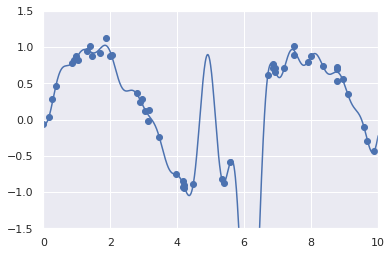

In [ ]:
#GaussianFeatures(ガウス基底)してからLinearRegression
model = make_pipeline(GaussianFeatures(30),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);
#→過学習してる

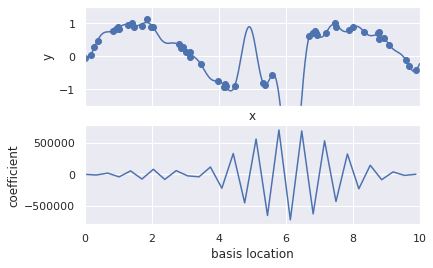

In [ ]:
#基底関数の推移をプロットしてみる(ax[1]　下の方のグラフ)
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

L2正則化  

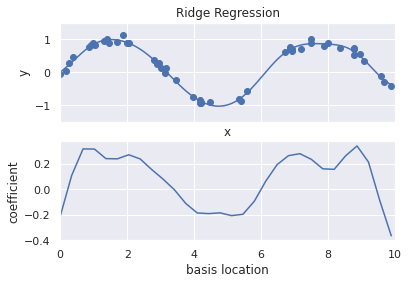

In [ ]:
#scikit-learnでは.linear_modelのRidge
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')
#alphaを増やす　-> 正則化が強くなる -> モデルは簡潔になる
#alphaを減らす　-> 正則化が弱くなる -> モデルは複雑になる

L1正則化  

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.136e-03, tolerance: 2.065e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


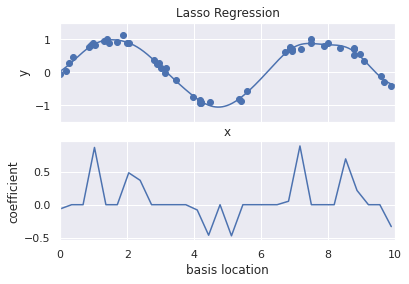

In [ ]:
##scikit-learnでは.linear_modelのLasso
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title='Lasso Regression')

実例  
→天気，季節などの要因に基づいて橋の自動車の交通量を予測

In [ ]:
!curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4541k    0 4541k    0     0  1583k      0 --:--:--  0:00:02 --:--:-- 1582k


In [ ]:
!git clone https://github.com/jakevdp/PythonDataScienceHandbook.git

fatal: destination path 'PythonDataScienceHandbook' already exists and is not an empty directory.


In [ ]:
import pandas as pd
counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('/content/PythonDataScienceHandbook/notebooks/data/BicycleWeather.csv', index_col='DATE', parse_dates=True)

In [ ]:
counts.head()

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2019-11-01 00:00:00,12.0,7.0,5.0
2019-11-01 01:00:00,7.0,0.0,7.0
2019-11-01 02:00:00,1.0,0.0,1.0
2019-11-01 03:00:00,6.0,6.0,0.0
2019-11-01 04:00:00,6.0,5.0,1.0


In [ ]:
weather.head()

,STATION,STATION_NAME,PRCP,SNWD,SNOW,TMAX,TMIN,AWND,WDF2,WDF5,WSF2,WSF5,FMTM,WT14,WT01,WT17,WT05,WT02,WT22,WT04,WT13,WT16,WT08,WT18,WT03
DATE,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-01,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,128,50,47,100,90,89,112,-9999,1,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2012-01-02,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,109,0,0,106,28,45,180,200,130,179,-9999,-9999,1,-9999,-9999,-9999,-9999,-9999,1,1,-9999,-9999,-9999
2012-01-03,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,8,0,0,117,72,23,180,170,54,67,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,1,-9999,-9999,-9999
2012-01-04,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,203,0,0,122,56,47,180,190,107,148,-9999,-9999,1,-9999,-9999,-9999,-9999,-9999,1,1,-9999,-9999,-9999
2012-01-05,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,13,0,0,89,28,61,200,220,107,165,-9999,-9999,1,-9999,-9999,-9999,-9999,-9999,-9999,1,-9999,-9999,-9999


In [ ]:
'''
.resample(),.asfreq()は時系列データを処理する関数
.resample('d')で日付でまとめる，.sum()，.mean()，.count()などが使える→.groupby()みたいなもの
ちなみに.resample('w')で週，.resample('m')で月
その他はhttps://note.nkmk.me/python-pandas-time-series-freq/
また，.asfreq()でアンダーサンプリング，オーバーサンプリングもできる
'''
#日付でまとめて.sum()で列を1つにまとめてしまう
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']]
daily.head()

,Total
Date,
2012-10-03,14084.0
2012-10-04,13900.0
2012-10-05,12592.0
2012-10-06,8024.0
2012-10-07,8568.0


In [ ]:
#曜日の列を追加してフラグを入れる
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Date,,,,,,,,
2012-10-03,14084.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-10-04,13900.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-10-05,12592.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-10-06,8024.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2012-10-07,8568.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
#休日の列を追加
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)
daily.head(7)

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday
Date,,,,,,,,,
2012-10-03,14084.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2012-10-04,13900.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-10-05,12592.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-10-06,8024.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-10-07,8568.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2012-10-08,14148.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2012-10-09,14004.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(8.0, 17.0)

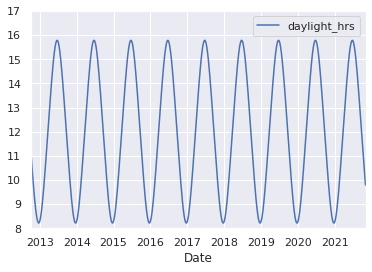

In [ ]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    #日照時間を計算
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

In [ ]:
#平均気温と降水量も付ける
#平均気温→1/10℃になってるので℃に変換
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

#降水量→インチに変換
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

In [ ]:
#日にちの増加量を付ける(1年経過で1になる)
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [ ]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,14084.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000
2012-10-04,13900.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740
2012-10-05,12592.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479
2012-10-06,8024.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219
2012-10-07,8568.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959


In [ ]:
#線形回帰で学習してみる
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

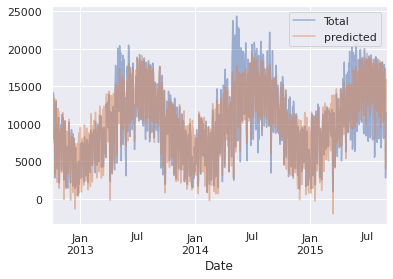

In [ ]:
daily[['Total', 'predicted']].plot(alpha=0.5);

In [ ]:
#評価してみる
from sklearn.metrics import mean_absolute_error as mae
mae(daily['Total'],daily['predicted'])

1388.5557457194072

In [ ]:
from sklearn.metrics import mean_squared_error as mse
mse(daily[['Total']],daily[['predicted']])

3322113.6106078085

→全体的にまだまだな精度  
mseが大きいため，大きい誤差があるデータがある  
図を見ると，夏あたりの誤差が大きそう  
→夏休みの特徴を入れると精度が上がりそう  

In [ ]:
#列ごとの重み（結果に与える影響）を計算
params = pd.Series(model.coef_, index=X.columns)
params

Mon             2019.531023
Tue             2440.935744
Wed             2370.694566
Thu             1929.432461
Fri              711.921382
Sat            -4413.206842
Sun            -4534.268983
holiday        -4749.605523
daylight_hrs     515.406045
PRCP           -2659.339527
dry day         2190.794369
Temp (C)         260.651164
annual           107.770852
dtype: float64

In [ ]:
#影響と不確実性を計算
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

In [ ]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

              effect  error
Mon           2020.0  345.0
Tue           2441.0  333.0
Wed           2371.0  331.0
Thu           1929.0  341.0
Fri            712.0  324.0
Sat          -4413.0  318.0
Sun          -4534.0  332.0
holiday      -4750.0  653.0
daylight_hrs   515.0   36.0
PRCP         -2659.0  249.0
dry day       2191.0  133.0
Temp (C)       261.0   14.0
annual         108.0   71.0


わからなかったこと  
* そもそもなんで切片が重みになるの？  
* 重みが高いほどどういうことが言えるの？  
* 重みがマイナスだとどうなの？  
* 特徴量ごとの重みってどういう計算してるの？  
* 不確実性ってなんなん？
